In [74]:
import numpy as np
import sys
sys.path.insert(1,'../../src')
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *
import _tracking as tk
from utils_JK import *
import seaborn as sns
sns.set_theme(context='paper',font_scale=1.0, style = 'ticks', color_codes='deep')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = np.load('test_3.npz',allow_pickle=True)
data_true = np.load('test_3_true.npz',allow_pickle=True)
lambds_out = data['arr_0']
phis_out = data['arr_1']
true_w = data_true['arr_0']
true_phi = data_true['arr_1']

In [71]:
freqs_out = rad2toHz(lambds_out)

mode_traces2 = tk.perform_tracking_continuous(freqs_out, phis_out, tcheck = 15, m = 3, df_max=0.15, dmac_max=0.2, update=True)

In [50]:
id_sort = np.argsort(true_w[0])
true_w_sorted = true_w[:,id_sort]
true_phi_sorted = true_phi[id_sort,:,:]
true_f_sorted = true_w_sorted/(2*np.pi)

In [83]:
test1 = n_skipped_time_seg_clustering2(freqs_out=freqs_out, phis_out=phis_out, true_freqs=true_f_sorted, true_phi=true_phi_sorted, df_lim=0.15, dmac_lim = 0.2)
print(test1)
# cnt = 0
# for k, fk in enumerate(true_f_sorted):
#     print('True freqs:', fk[0])
#     print('Koma freqs:', lambds_out[k][0]/(2*np.pi))
#     dmac = 1 - MAC(true_phi_sorted[0,:,k], phis_out[k][0,:])
#     df = rel_diff(fk[0],lambds_out[k][0]/(2*np.pi))
#     print('mac:',MAC(true_phi_sorted[0,:,k], phis_out[k][0,:]))
#     print('dmac:',dmac)
#     if df >= 0.2 and dmac >= 0.1: 
#         print('Missed')
#         cnt += 1
#         print('cnt:',cnt)
#     print('-------------------------------------------')

# print('cnt:',cnt)

k: 0
True freq: 0.39345265723338635
Koma freq: 0.24993507762882325
dmac: 0.004848790454732188
----------------------
k: 0
True freq: 0.40931885254297345
Koma freq: 0.2570105013520857
dmac: 0.04230787153403626
----------------------
k: 0
True freq: 1.0300724296009676
Koma freq: 0.40513478063912495
dmac: 0.005435249762202887
----------------------
k: 0
True freq: 1.1715545520019277
Koma freq: 0.43116653408014155
dmac: 0.002113230689387846
----------------------
k: 1
True freq: 0.39446945288794405
Koma freq: 0.2500427067330554
dmac: 0.017231733858901976
----------------------
k: 1
True freq: 0.4126378607883049
Koma freq: 0.257435208185876
dmac: 0.007109814787899182
----------------------
k: 1
True freq: 1.03367142146277
Koma freq: 0.40537902396938014
dmac: 0.0005719911470352113
----------------------
k: 1
True freq: 1.1768272394252428
Koma freq: 0.432744395240289
dmac: 0.00027438685950842423
----------------------
k: 2
True freq: 0.3954839023945673
Koma freq: 0.25021352164418187
dmac: 0.0

In [69]:
for i, trace in enumerate(mode_traces2):
    if not trace.isphysical: continue
    print(trace.n_skipped_time_seg)

108
103
30
21
102
53
24
10
0


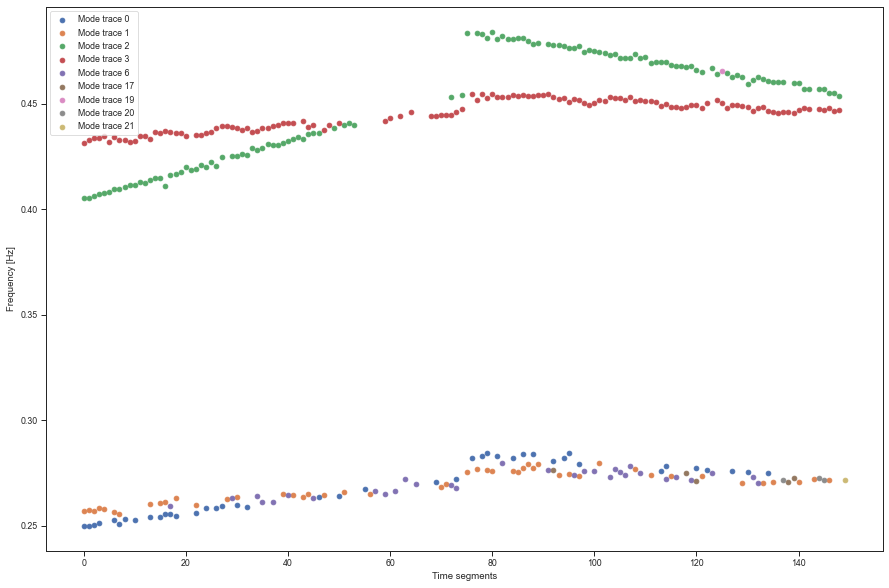

In [72]:
fig, axs = plt.subplots(figsize = (15,10))

for i, trace in enumerate(mode_traces2):
    if not trace.isphysical: continue
    axs.scatter(trace.time_seg, trace.frequencies, label = 'Mode trace {}'.format(i))
    

axs.set_xlabel('Time segments')
axs.set_ylabel('Frequency [Hz]')
axs.legend()

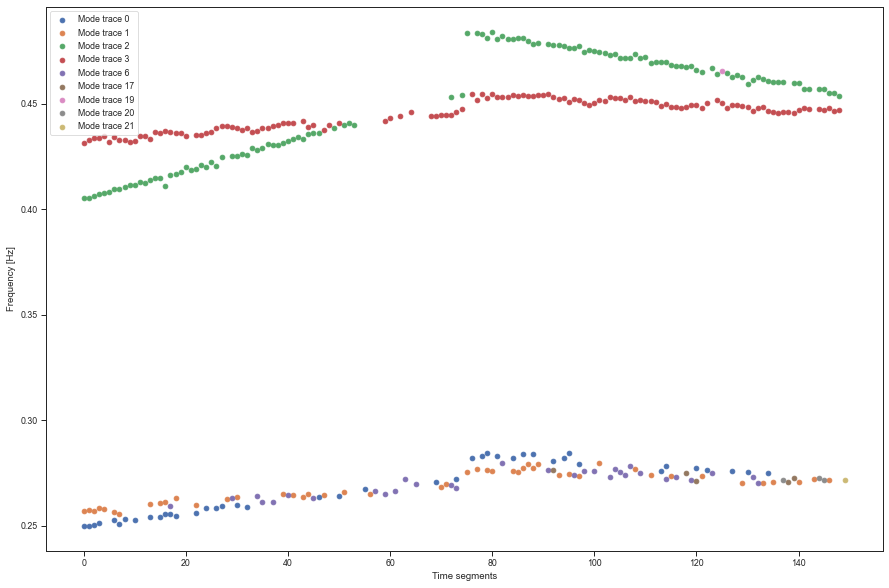

In [67]:
axs = plot_physical_traces(mode_traces2)

plt.show(axs)

In [5]:
def n_skipped_time_seg_clustering(freqs_out, phis_out, true_freqs, true_phi, lim = 0.01):
    n = np.zeros_like(true_freqs[0])
    for k, freqs_out_k in enumerate(freqs_out):
        for j, freqs_out_kj in enumerate(freqs_out_k):
            phis_out_kj = phis_out[k][j,:]
            d_temp = np.array([])
            for i, true_mode_freq_i in enumerate(true_freqs[k]):
                true_phi_i = true_phi[i,:,k]
                d_temp = np.append(d_temp, rel_diff(true_mode_freq_i, freqs_out_kj) + 1 - MAC(true_phi_i, phis_out_kj))
            id_min = np.argmin(d_temp)
            if d_temp[id_min] <= lim:
                continue
            else:
                n[id_min] += 1
    return n

In [6]:
id_sort = np.argsort(true_w[0])
true_w_sorted = true_w[:,id_sort]
true_phi_sorted = true_phi[id_sort,:,:]
true_f_sorted = true_w_sorted/(2*np.pi)
freqs_out = rad2toHz(lambds_out)

In [13]:
n_test = np.array([20,25,30,35,40])
m_test = np.array([5,8,11,14,17,20,26,32])
d_track_threshold_test = np.array([0.010, 0.050, 0.075, 0.100, 0.200, 0.300, 0.350, 0.500, 0.800])
result_dict = {}

In [16]:
for ni in n_test:
    for mi in m_test:
        for d_track_threshold_i in d_track_threshold_test:
            mode_traces_i = tk.perform_tracking(freqs_out, phis_out, n = ni, m = mi, d_track_threshold=d_track_threshold_i,method='average')
            n_skipped_clustering = n_skipped_time_seg_clustering(freqs_out[ni:], phis_out[ni:], true_f_sorted[ni:], true_phi_sorted[:,:,ni:], lim = d_track_threshold_i)
            if len(mode_traces_i) != 4:
                result_dict[ni, mi, d_track_threshold_i] = None
            else:
                temp_n_skipped_time_seg = []
                temp_error = []
                temp_time_seg = []
                temp_frequencies = []
                for k, mode_traces_ik in enumerate(mode_traces_i):
                    mode_traces_ik.set_error(true_w_sorted[:,k]/(2*np.pi))
                    temp_n_skipped_time_seg.append(mode_traces_ik.n_skipped_time_seg) 
                    temp_error.append(mode_traces_ik.error)
                    temp_time_seg.append(mode_traces_ik.time_seg)
                    temp_frequencies.append(mode_traces_ik.frequencies)
                result_dict[ni, mi, d_track_threshold_i] = temp_time_seg, temp_frequencies, temp_error, temp_n_skipped_time_seg - n_skipped_clustering


In [17]:
np.savez('result_average', result_dict=result_dict)